In [2]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import os
import argparse
import numpy as np

from utils import progress_bar


from pprint import pprint as pp
from scipy import linalg

from utils import FlowLayout
import seaborn as sns
import matplotlib.pyplot as plt

print('#GPU: ', torch.cuda.device_count())
print('PyTorch Version:', torch.__version__)
np.set_printoptions(precision=2)

#GPU:  4
PyTorch Version: 1.6.0+cu92


In [4]:
def toeplitz_1_ch(kernel, input_size):
    # shapes
    k_h, k_w = kernel.shape
    i_h, i_w = input_size
    o_h, o_w = i_h-k_h+1, i_w-k_w+1

    # construct 1d conv toeplitz matrices for each row of the kernel
    toeplitz = []
    for r in range(k_h):
        toeplitz.append(linalg.toeplitz(c=(kernel[r,0], *np.zeros(i_w-k_w)), r=(*kernel[r], *np.zeros(i_w-k_w))) ) 

    # construct toeplitz matrix of toeplitz matrices (just for padding=0)
    h_blocks, w_blocks = o_h, i_h
    h_block, w_block = toeplitz[0].shape

    W_conv = np.zeros((h_blocks, h_block, w_blocks, w_block))

    for i, B in enumerate(toeplitz):
        for j in range(o_h):
            W_conv[j, :, i+j, :] = B

    W_conv.shape = (h_blocks*h_block, w_blocks*w_block)

    return W_conv

def toeplitz_mult_ch(kernel, input_size):
    """Compute toeplitz matrix for 2d conv with multiple in and out channels.
    Args:
        kernel: shape=(n_out, n_in, H_k, W_k)
        input_size: (n_in, H_i, W_i)"""

    kernel_size = kernel.shape
    output_size = (kernel_size[0], input_size[1] - (kernel_size[2]-1), input_size[2] - (kernel_size[3]-1))
    print('==> output_size', output_size)
    T = np.zeros((output_size[0], int(np.prod(output_size[1:])), input_size[0], int(np.prod(input_size[1:]))))
    print('==> T', T.shape)

    for i,ks in enumerate(kernel):  # loop over output channel
        for j,k in enumerate(ks):  # loop over input channel
            T_k = toeplitz_1_ch(k, input_size[1:])
            T[i, :, j, :] = T_k

    T.shape = (np.prod(output_size), np.prod(input_size))

    return T





class InvConv(nn.Module):
    def __init__(self):
        super(InvConv, self).__init__()
        self.if_init = False

    def init_layer(self, old_layer):
        self.old_weight = old_layer.weight.detach().cpu().clone().numpy()
        self.inp_padding = old_layer.padding
        
        self.inp_size = list(old_layer.inp_size)[1:] # inp_size was obtained by hook
        
        
        if old_layer.padding[-1]>0:
            self.inp_size[-1] += 2*old_layer.padding[-1]
        if old_layer.padding[-2]>0:
            self.inp_size[-2] += 2*old_layer.padding[-2]
            
        print('inp_size:', self.inp_size)
        print('old weight', self.old_weight.shape)
        self.old_weight_matrix = toeplitz_mult_ch(
            self.old_weight, self.inp_size)
        self.old_weight_matrix = torch.tensor(self.old_weight_matrix).float()
        
        
        self.if_init = True
        
    def forward(self, y, if_inv=True):
        '''
        Problem: 
            1. the converted weight matrix is super large. This matrix may consum ~150G memory. Please do NOT use cuda. 
        '''
        
        assert self.if_init

        # remember to transpose the old_weight_matrix
        self.old_weight_matrix = self.old_weight_matrix.to(y.device)
            
        if if_inv:
            '''
            inversion of convolution
            '''
            y = y.contiguous()
            out = torch.matmul(self.old_weight_matrix.t()[None,:,:], y.view(y.size(0), -1)[:,:,None])

            # reshape the output
            out = out.view([out.size(0)] + self.inp_size)

            # un-padding
            if self.inp_padding[0] == 0 and self.inp_padding[1]==0:
                out_unpadding = out
            else:
                out_unpadding = out[:,:,self.inp_padding[0]:-self.inp_padding[0],self.inp_padding[1]:-self.inp_padding[1]]

            return out_unpadding
        else:
            '''
            standard convolution. However, we implement the convolution with pure matrix(weights)-vector(input) multiplication.
            
            '''
            x = y
            x_pad = F.pad(x, pad=[self.inp_padding[0],self.inp_padding[0],self.inp_padding[1],self.inp_padding[1]])
            print('### x_pad', x_pad.view(x_pad.size(0), -1)[:,:,None].size())
            out = torch.matmul(self.old_weight_matrix[None,:,:], x_pad.view(x_pad.size(0), -1)[:,:,None])
            # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv#torch.nn.Conv2d
            out_size = int( (self.inp_size[-1] - 1 * (self.old_weight.shape[-1] -1) - 1)  / 1. + 1)
            out = out.view([out.size(0), self.old_weight.shape[0]]+[out_size]*2)
            return out



In [5]:
# define the model

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x, out_idx=False):
        # out = self.features(x)
        out = self.features[0](x)
        out = self.features[1](out)
        out = self.features[2](out)
        out, idx03 = self.features[3](out)
        out = self.features[4](out)
        out = self.features[5](out)
        out = self.features[6](out)
        out, idx07 = self.features[7](out)
        out = self.features[8](out)
        out = self.features[9](out)
        out = self.features[10](out)
        out = self.features[11](out)
        out = self.features[12](out)
        out = self.features[13](out)
        out, idx14 = self.features[14](out)
        out = self.features[15](out)
        out = self.features[16](out)
        out = self.features[17](out)
        out = self.features[18](out)
        out = self.features[19](out)
        out = self.features[20](out)
        out, idx21 = self.features[21](out)
        out = self.features[22](out)
        out = self.features[23](out)
        out = self.features[24](out)
        out = self.features[25](out)
        out = self.features[26](out)
        out = self.features[27](out)
        out, idx28 = self.features[28](out)
        out = self.features[29](out)
        
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        
        if out_idx:
            return out, (idx03, idx07, idx14, idx21, idx28)
        else:
            return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=False)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


In [6]:
# Preparing data..
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='/dev/shm', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(
    root='/dev/shm', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [7]:
device = 'cpu'
lr = 0.01
epochs = 100
best_acc = 0

net = VGG('VGG11').to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True

# if args.resume:
#     # Load checkpoint.
#     print('==> Resuming from checkpoint..')
#     assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
#     checkpoint = torch.load('./checkpoint/ckpt.pth')
#     net.load_state_dict(checkpoint['net'])
#     best_acc = checkpoint['acc']
#     start_epoch = checkpoint['epoch']
start_epoch = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        # state = {
        #     'net': net.module.state_dict(),
        #     'acc': acc,
        #     'epoch': epoch,
        # }
        # torch.save(state, './cifar_vgg_11.pth')
        best_acc = acc


# for epoch in range(start_epoch, start_epoch+epochs):
#     train(epoch)
#     test(epoch)
#     scheduler.step()

checkpoint = torch.load('./cifar_vgg_11.pth')
net.load_state_dict(checkpoint['net'])


        
def InpSizeHook(module, input, output):
    module.inp_size = input[0].size()
    
for n,m in net.named_modules():
    if n!='' and n!='features':
        m.register_forward_hook(InpSizeHook)
    
test(0)

 [================================================================>]  Step: 29ms | Tot: 9s364ms | Loss: 0.466 | Acc: 89.690% (8969/10000) 157/157 


In [8]:
for n,m in net.named_modules():
    if n!='' and n!='features':
        print(n,'||',m, '||',m.inp_size)
        # print()
        # if '9' in n:
        #     break

features.0 || Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) || torch.Size([16, 3, 32, 32])
features.1 || BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) || torch.Size([16, 64, 32, 32])
features.2 || ReLU() || torch.Size([16, 64, 32, 32])
features.3 || MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) || torch.Size([16, 64, 32, 32])
features.4 || Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) || torch.Size([16, 64, 16, 16])
features.5 || BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) || torch.Size([16, 128, 16, 16])
features.6 || ReLU() || torch.Size([16, 128, 16, 16])
features.7 || MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) || torch.Size([16, 128, 16, 16])
features.8 || Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) || torch.Size([16, 128, 8, 8])
features.9 || BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [9]:
class InvVGG(nn.Module):
    def __init__(self):
        super(InvVGG, self).__init__()
        # self.classifier = nn.Linear(10, 512)
        # self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        # self.f26 = nn.BatchNorm2d(512)
        # self.f25 = InvConv()
        # self.f23 = nn.BatchNorm2d(512)
        # self.f22 = InvConv()
        # self.f19 = nn.BatchNorm2d(512)
        # self.f18 = InvConv()
        # self.f16 = nn.BatchNorm2d(512)
        # self.f15 = InvConv()
        # self.f12 = nn.BatchNorm2d(256)
        # self.f11 = InvConv()
        # self.f09 = nn.BatchNorm2d(256)
        # self.f08 = InvConv()
        # self.f05 = nn.BatchNorm2d(128)
        # self.f04 = InvConv()
        # self.f01 = nn.BatchNorm2d(64)
        self.f00 = InvConv()
        
    def forward(self, out, idx03, idx07, idx14, idx21, idx28):
        # out = self.classifier(out)
        # out = out.view(out.size(0), 512, 1, 1)

        # out = self.unpool(out, idx28)  # f 28, pool
        # # print('out 28:', out.size())
        # out = self.f26(out)            # f 26, bn
        # # print('out 26:', out.size())
        # out = self.f25(out)            # f 25, conv
        # out = self.f23(out)              # f 23, bn
        # out = self.f22(out)              # f 22, conv
        # out = self.unpool(out, idx21)  # f 21, pool
        # out = self.f19(out)            # f 19, bn
        # out = self.f18(out)            # f 18, conv
        # out = self.f16(out)            # f 16, bn
        # out = self.f15(out)            # f 15, conv
        # out = self.unpool(out, idx14)  # f 14, pool
        # out = self.f12(out)            # f 12, bn
        # out = self.f11(out)            # f 11, conv
        # out = self.f09(out)            # f 09, bn
        # out = self.f08(out)            # f 08, conv
        # out = self.unpool(out, idx07)  # f 07, pool
        # out = self.f05(out)            # f 05, bn
        # out = self.f04(out)            # f 04, conv
        # out = self.unpool(out, idx03)  # f 03, pool
        # out = self.f01(out)            # f 01, bn
        out = self.f00(out)            # f 00, conv
        
        return out
    
inv_net = InvVGG()
    


In [10]:
# conv
# inv_net.f25.init_layer(net.features[25])
# inv_net.f22.init_layer(net.features[22])
# inv_net.f18.init_layer(net.features[18])
# inv_net.f15.init_layer(net.features[15])
# inv_net.f11.init_layer(net.features[11])
# inv_net.f08.init_layer(net.features[8])
# inv_net.f04.init_layer(net.features[4])
inv_net.f00.init_layer(net.features[0])

inp_size: [3, 34, 34]
old weight (64, 3, 3, 3)
==> output_size (64, 32, 32)
==> T (64, 1024, 3, 1156)


In [11]:
all_inp_l = []
for i in range(10):
    all_inp_l.append(torch.load('/project/kung/xin/cifar_vgg11_saved_model/c%d.pth'%i)['features.0'])
all_inp = torch.cat(all_inp_l)

stat_bsz = 128
realinp_dataset = torch.utils.data.TensorDataset(all_inp)
realinp_loader = torch.utils.data.DataLoader(realinp_dataset, batch_size=stat_bsz, shuffle=True)

mean_list = []
std_list = []
for data in realinp_loader:
    mean = data[0].mean([0,2,3])
    std  = data[0].std([0,2,3], unbiased=False)
    mean_list.append(mean)
    std_list.append(std)
    
print(mean_list[0].size())

all_mean = torch.stack(mean_list).mean([0])
all_std  = torch.stack(std_list).mean([0])

print(all_mean)
print(all_std)

# oPlot = FlowLayout() # create an empty FlowLayout
# for i in range(3): 
#     fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9))
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
#     sns.histplot([t[i].item() for t in mean_list], stat='probability', kde=True)
#     fig.tight_layout()
#     # fig.suptitle('Output of Conv2d', fontsize=16)
#     oPlot.add_plot(ax) 
#     plt.close() 
# oPlot.PassHtmlToCell()    


# oPlot = FlowLayout() # create an empty FlowLayout
# for i in range(3): 
#     fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9))
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
#     sns.histplot([t[i].item() for t in std_list], stat='probability', kde=True)
#     fig.tight_layout()
#     # fig.suptitle('Output of Conv2d', fontsize=16)
#     oPlot.add_plot(ax) 
#     plt.close() 
# oPlot.PassHtmlToCell()    

torch.Size([3])
tensor([-0.3294, -0.3372, -0.3112])
tensor([1.3969, 1.3922, 1.4134])


In [ ]:
def normalize_to(inp, mean, std):
    inp_mean = inp.mean([0,2,3], keepdim=True)
    inp_std  = inp.std([0,2,3], unbiased=False, keepdim=True)
    return ((inp-inp_mean)/inp_std)*std + mean


all_f0out_l = []
all_target_l = []
for i in range(10):
    all_f0out_l.append(torch.load('/project/kung/xin/cifar_vgg11_saved_model/c%d.pth'%i)['features.1'])
    all_target_l.append(torch.load('/project/kung/xin/cifar_vgg11_saved_model/c%d.pth'%i)['target'])
all_f0out = torch.cat(all_f0out_l)
all_target = torch.cat(all_target_l)

stat_bsz = 128
realinp_dataset = torch.utils.data.TensorDataset(all_f0out, all_target)
realinp_loader = torch.utils.data.DataLoader(realinp_dataset, batch_size=stat_bsz, shuffle=True)

realmean = torch.tensor([-0.3295, -0.3372, -0.3112]).view(1,3,1,1)
realstd  = torch.tensor([1.3969, 1.3923, 1.4135]).view(1,3,1,1)


net.eval()

total = 0
correct = 0

for idx, (f0out, targets) in enumerate(realinp_loader):
    inverted_img = inv_net(f0out, None, None, None, None, None)

    
    # input back
    outputs = net(normalize_to(inverted_img, realmean, realstd))
    # outputs = net(inverted_img)
    
    _, predicted = outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
    
    acc = 100.*correct/total
    print('Acc: %.4f'%acc)

Acc: 70.3125
Acc: 71.0938
Acc: 66.6667
Acc: 66.6016
Acc: 66.0938
Acc: 66.2760
Acc: 66.6295
Acc: 66.2109
Acc: 66.1458
Acc: 66.3281
Acc: 65.6960
Acc: 65.8854
Acc: 65.6851
Acc: 65.8482
Acc: 65.4688
Acc: 65.6250
Acc: 65.6250
Acc: 65.2778
Acc: 65.2549
Acc: 65.3906
Acc: 65.4390
Acc: 65.5540
Acc: 65.4552
Acc: 65.6901
Acc: 65.7188
Acc: 65.7752
Acc: 65.7697
Acc: 65.6808
Acc: 65.6519
Acc: 65.6771
Acc: 65.7510
Acc: 65.9180
Acc: 65.7434
Acc: 65.7858
Acc: 65.9375
Acc: 65.9505
Acc: 65.9206
Acc: 65.9539
Acc: 66.0657
Acc: 65.9766
Acc: 66.0442
Acc: 66.1086
Acc: 66.1701
Acc: 66.2820
Acc: 66.1458
Acc: 66.0326
Acc: 66.0572
Acc: 66.1296
Acc: 66.0874
Acc: 66.1562
Acc: 66.1765
Acc: 66.2260
Acc: 66.2588
Acc: 66.3484
Acc: 66.3778
Acc: 66.3086
Acc: 66.3651
Acc: 66.3389
Acc: 66.2606
Acc: 66.1719
Acc: 66.2013
Acc: 66.2550
Acc: 66.1830
Acc: 66.2842
Acc: 66.3702
Acc: 66.3352
Acc: 66.4412
Acc: 66.4292
Acc: 66.5195
Acc: 66.4955
Acc: 66.5493
Acc: 66.5256
Acc: 66.5454
Acc: 66.6385
Acc: 66.6875
Acc: 66.6941
Acc: 66.7309

In [14]:
# for class 0
saved = torch.load('/project/kung/xin/cifar_vgg11_saved_model/c0.pth')


out_features0 = saved['features.1'][0:256]
print(out_features0.size())

inverted_img = inv_net(out_features0, None, None, None, None, None)
print(inverted_img.size())

mean = inverted_img.mean([0,2,3], keepdim=True)
std  = inverted_img.std([0,2,3], unbiased=False, keepdim=True)
print(mean)
print(std)

realmean = torch.tensor([-0.3295, -0.3372, -0.3112]).view(1,3,1,1)
realstd  = torch.tensor([1.3969, 1.3923, 1.4135]).view(1,3,1,1)

torch.Size([256, 64, 32, 32])
torch.Size([256, 3, 32, 32])
tensor([[[[-1.2091]],

         [[-0.1625]],

         [[ 1.0091]]]], grad_fn=<MeanBackward1>)
tensor([[[[6.9776]],

         [[6.8763]],

         [[6.7350]]]], grad_fn=<StdBackward1>)


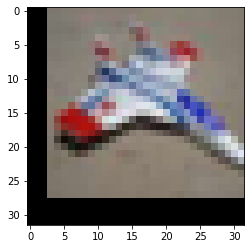

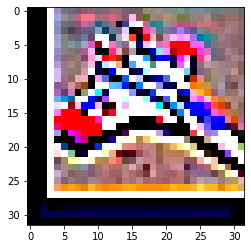

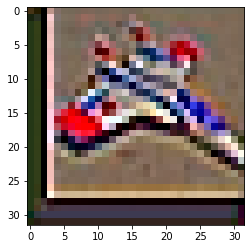

In [13]:
import matplotlib.pyplot as plt
from di import denormalize
img_idx = 1
plt.figure()
plt.imshow(denormalize(saved['features.0'][img_idx]).view(3,-1).T.view(32,32,3))
plt.figure()
plt.imshow(denormalize(inverted_img[img_idx]).reshape(3,-1).T.view(32,32,3).detach())
plt.figure()
plt.imshow(denormalize(((inverted_img[img_idx]-mean)/std)*realstd +realmean).view(3,-1).T.view(32,32,3).detach())


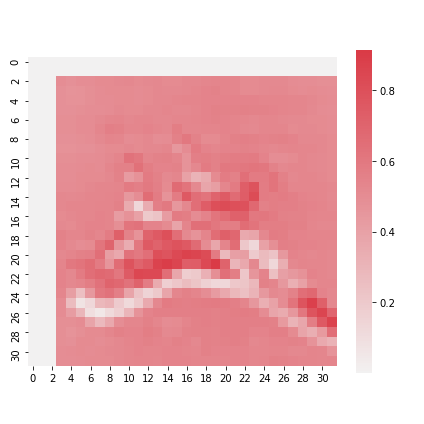
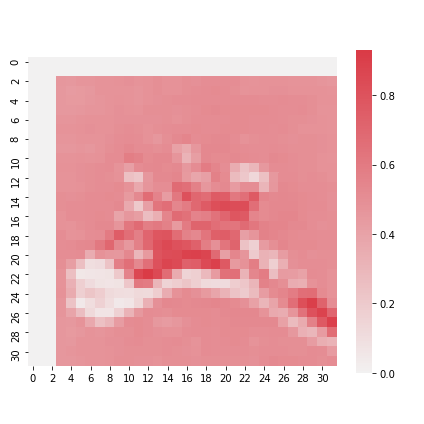
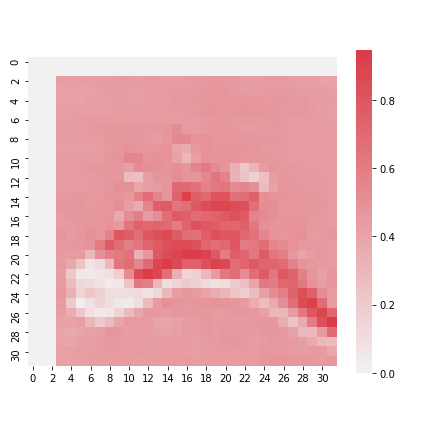


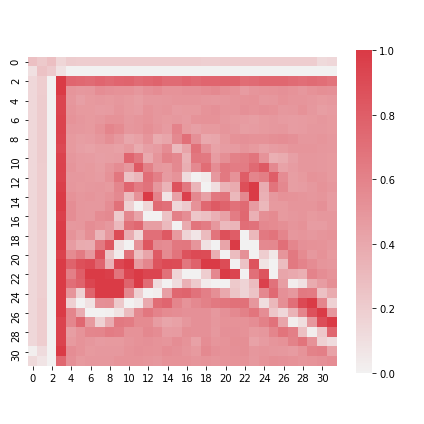
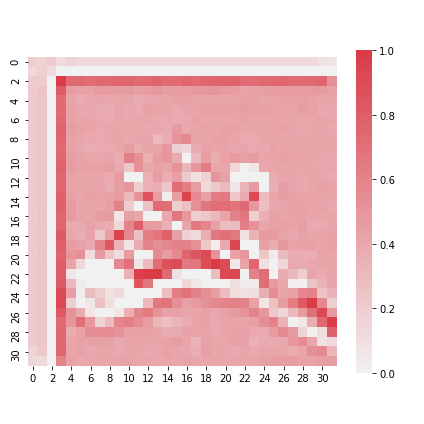
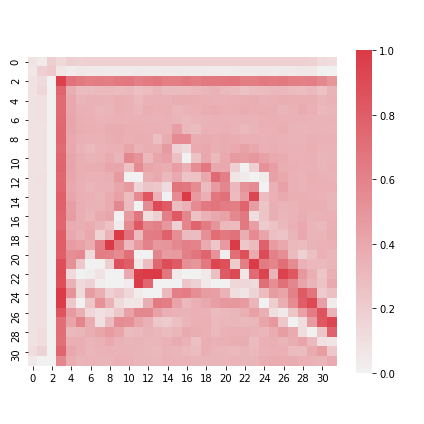

In [21]:


oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(3): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(denormalize(saved['features.0'][img_idx])[i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    # fig.suptitle('Output of Conv2d', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()



oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(3): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(denormalize(((inverted_img[img_idx]-mean)/std)*realstd +realmean)[0][i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    # fig.suptitle('Output of Conv2d', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()

In [ ]:
# def update_bn(inv_bn, old_bn):
#     inv_bn.bias.data = old_bn.running_mean.cpu()
#     inv_bn.weight.data = torch.sqrt(old_bn.running_var.cpu()+1e-8)

# def update_bn(inv_bn, old_bn):
#     inv_bn.bias.data = old_bn.running_mean.cpu()
#     inv_bn.weight.data = torch.sqrt(old_bn.running_var.cpu()+1e-8)
#     inv_bn.running_mean.data = old_bn.bias.cpu().data
#     inv_bn.running_var.data  = (old_bn.weight.cpu()**2).data

# # bn
# update_bn(inv_net.f01, net.features[1])
# update_bn(inv_net.f05, net.features[5])
# update_bn(inv_net.f09, net.features[9])
# update_bn(inv_net.f12, net.features[12])
# update_bn(inv_net.f16, net.features[16])
# update_bn(inv_net.f19, net.features[19])
# update_bn(inv_net.f23, net.features[23])
# update_bn(inv_net.f26, net.features[26])

In [ ]:
# fc
# inv_net.classifier.weight.data = net.classifier.weight.data.T.contiguous().clone()

In [ ]:
# class FeatureHook():
#     def __init__(self, module):
#         self.hook = module.register_forward_hook(self.hook_fn)

#     def hook_fn(self, module, input, output):
#         self.r_feature = input[0]

#     def close(self):
#         self.hook.remove()
        
        
# hook_dict = {}
# for n, m in net.named_modules():
#     if n!='' and n!='features':
#         hook_dict[n] = FeatureHook(m)

In [ ]:
# net.eval()
# # inv_net.train()
# inv_net.eval()


# device='cpu'

# root = '/project/kung/xin/cifar_vgg11_saved_model/gamma_beta_inverted_images/'

# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(trainloader):
#         data, target = data.to(device), target.to(device)
#         output, out_idx = net(data, True)

#         # real_features = {n:h.r_feature for n,h in hook_dict.items()}

#         inv_input = inv_net(output, out_idx[0], out_idx[1], out_idx[2], out_idx[3], out_idx[4])

#         # fake_output, fake_out_idx = net(inv_input, True)

#         # fake_features = {n:h.r_feature for n,h in hook_dict.items()}

#         # data_display = torch.cat((data,  inv_input), 0)
#         # print("displaying original input-inverted input pairs")
#         # vutils.save_image(data_display,'vgg_bn_gammabeta.png', normalize=True, scale_each=True, nrow=int(8))

#         torch.save({'real_inp':data, 'real_label':target, 'fake_inp':inv_input}, root+'b-%s.pth'%batch_idx)

In [ ]:
# all_bn_dict = {}

# for n, m in net.named_modules():
#     if isinstance(m, nn.BatchNorm2d):
#         all_bn_dict[n] = m

In [ ]:
# all_bn_dict

In [ ]:
# import glob, os
# import torch
# import seaborn as sns
# import matplotlib.pyplot as plt
# from di import denormalize
# import numpy as np

# from IPython.display import HTML
# import io
# import base64


# class FlowLayout(object):
#     ''' A class / object to display plots in a horizontal / flow layout below a cell '''
#     def __init__(self):
#         # string buffer for the HTML: initially some CSS; images to be appended
#         self.sHtml =  """
#         <style>
#         .floating-box {
#         display: inline-block;
#         margin: 1px;
#         border: 1px solid #888888;  
#         }
#         </style>
#         """

#     def add_plot(self, oAxes):
#         ''' Saves a PNG representation of a Matplotlib Axes object '''
#         Bio=io.BytesIO() # bytes buffer for the plot
#         fig = oAxes.get_figure()
#         fig.canvas.print_png(Bio) # make a png of the plot in the buffer

#         # encode the bytes as string using base 64 
#         sB64Img = base64.b64encode(Bio.getvalue()).decode()
#         self.sHtml+= (
#             '<div class="floating-box">'+ 
#             '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
#             '</div>')

#     def PassHtmlToCell(self):
#         ''' Final step - display the accumulated HTML '''
#         display(HTML(self.sHtml))


In [ ]:




# oPlot = FlowLayout() # create an empty FlowLayout

# for layer_name in all_bn_dict.keys(): # plot 10 charts
#     running_std = torch.sqrt(all_bn_dict[layer_name].running_var)
#     running_mean = all_bn_dict[layer_name].running_mean

#     real_std = real_features[layer_name].std([0, 2, 3], unbiased=False)
#     real_mean = real_features[layer_name].mean([0, 2, 3])

#     fake_std = fake_features[layer_name].std([0, 2, 3], unbiased=False)
#     fake_mean = fake_features[layer_name].mean([0, 2, 3])
    
#     fig, ax = plt.subplots(1, 1, figsize=(8,5.9))

#     ax.plot(running_mean.detach(), label='running mean', linewidth=3, alpha=0.5)
#     ax.plot(real_mean.detach(),    label='mean on real data', linewidth=3, alpha=0.5)
#     ax.plot(fake_mean.detach(),    label='mean on inverted data', linewidth=3, alpha=0.5)
#     ax.set_title('%s Certain Channel'%layer_name, fontsize=23)
#     ax.set_xlabel('channel index')
#     ax.legend(fontsize=20)
    
#     fig.tight_layout()
#     oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
#     plt.close() # this gets rid of the plot so it doesn't appear in the cell


# oPlot.PassHtmlToCell()

In [ ]:
# class FeatureHook():
#     def __init__(self, module):
#         self.hook = module.register_forward_hook(self.hook_fn)

#     def hook_fn(self, module, input, output):
#         self.r_feature = input[0]

#     def close(self):
#         self.hook.remove()
        
        
# hook_dict = {}
# for n, m in net.named_modules():
#     if n!='' and n!='features':
#         hook_dict[n] = FeatureHook(m)
        
# root_dir = '/project/kung/xin/cifar_vgg11_saved_model/'
        
# for class_idx in range(10):
#     t = np.array(trainset.targets)
#     indices = np.argwhere(t==class_idx).flatten().tolist()
#     sub_set = torch.utils.data.Subset(trainset, indices)
#     sub_loader = torch.utils.data.DataLoader(
#         sub_set, batch_size=len(sub_set), shuffle=False, num_workers=8)
#     for image, label in sub_loader:
#         output = net(image)
        
#     save_dict = {n:h.r_feature for n, h in hook_dict.items()}
#     save_dict['output'] = output
    
#     torch.save(save_dict, root_dir+'c'+str(class_idx)+'.pth')